In [1]:
%matplotlib inline
import os
import time
import numpy
import pandas as pd
import matplotlib

In [3]:
log_files = {1: 'slurm-3600.out', 4: 'slurm-3601.out', 16: 'slurm-3602.out'}

In [8]:
 def log_file_to_dataframe(log_file):
    fp = open(log_file, 'r')
    perf_records = []
    for line in fp:
        if line.startswith('PE ') and line.find('- total') != -1:
            tokens = line.split()

            # Sample line in log file:
            #   PE 6 - total 1336.802000 ms - metadata 54.481000 ms (50.733000 0.000000) - \
            #     summary 3.805000 ms (1.763000 0.072000 1.970000 | 0.065000 0.037000 0.048000 1.820000) - \
            #     edges 1278.047000 ms (1190.644000 80.641000) - neighbor updates 0.411000 ms - \
            #     abort 0.058000 ms - 0 spins - 9 / 16 PE neighbors  - partition window = , 1522 / 28900 active - \
            #     aborting? 0 - last step? 0 - remote cache hits=6688 misses=3553 age misses=0, feature cache hits=0 misses=0
            pe = int(tokens[1])
            total = float(tokens[4])
            metadata = float(tokens[8])
            summary = float(tokens[14])
            edges = float(tokens[26])
            neighbor_updates = float(tokens[33])
            abort = float(tokens[37])
            spins = int(tokens[40])
            n_neighbors = int(tokens[43])
            active_partitions = int(tokens[53])
            cache_hits_str = tokens[67]
            cache_hits = int(cache_hits_str.split('=')[1])
            cache_misses_str = tokens[68]
            cache_misses = int(cache_misses_str.split('=')[1])
            cache_age_misses_str = tokens[70]
            cache_age_misses_str = cache_age_misses_str.split('=')[1]
            cache_age_misses_str = cache_age_misses_str[:-1]
            cache_age_misses = int(cache_age_misses_str)

            perf_records.append({'pe': pe,
                                 'total': total,
                                 'metadata': metadata,
                                 'summary': summary,
                                 'edges': edges,
                                 'neighbor_updates': neighbor_updates,
                                 'abort': abort,
                                 'spins': spins,
                                 'n_neighbors': n_neighbors,
                                 'active_partitions': active_partitions,
                                 'cache_hits': cache_hits,
                                 'cache_misses': cache_misses,
                                 'cache_age_misses': cache_age_misses})
    fp.close()
    return pd.DataFrame(perf_records)

In [9]:
dfs = {}
for nnodes in log_files:
    dfs[nnodes] = log_file_to_dataframe(log_files[nnodes])

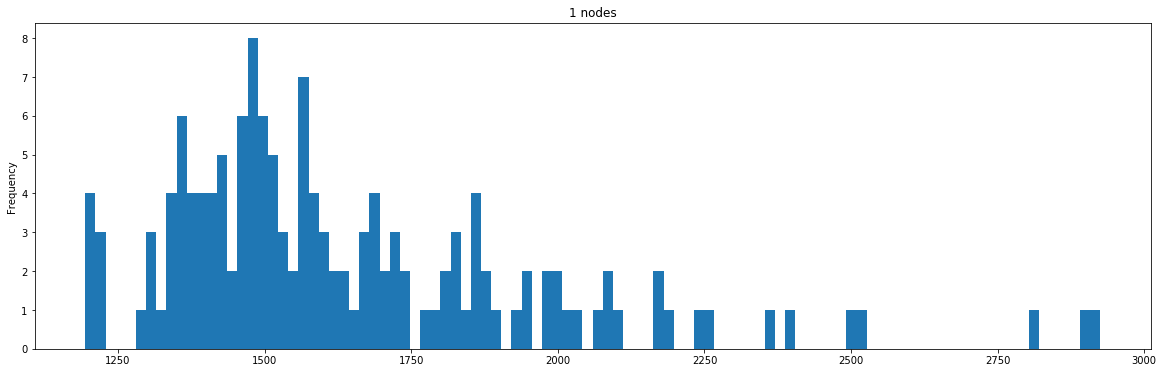

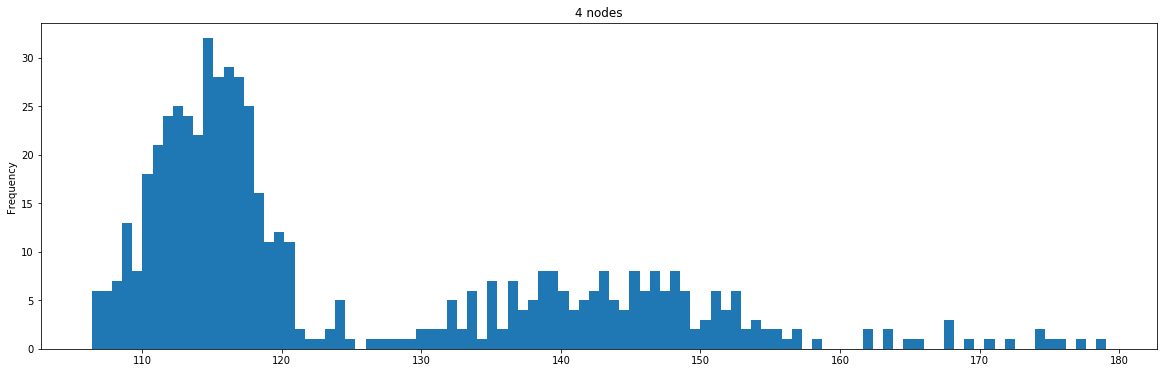

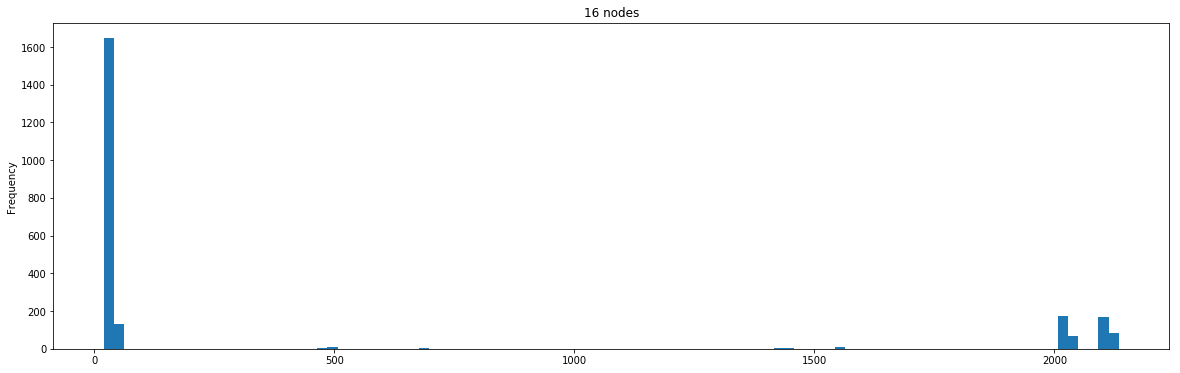

In [23]:
for nnodes in sorted(dfs.keys()):
    fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
    dfs[nnodes]['total'].plot(kind = 'hist', bins = 100, ax = ax, title = str(nnodes) + ' nodes')

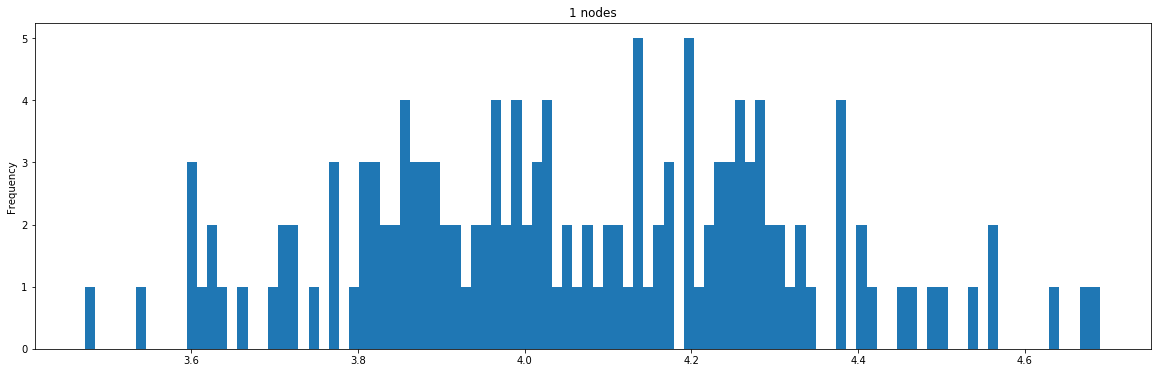

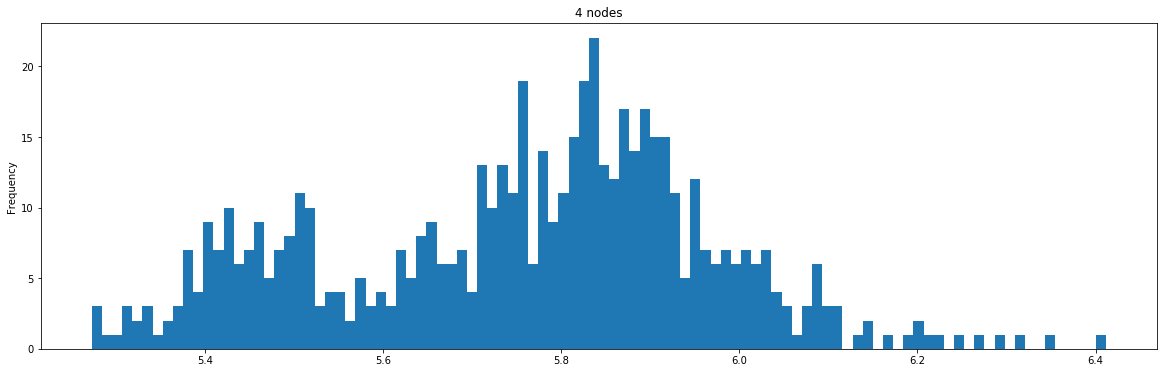

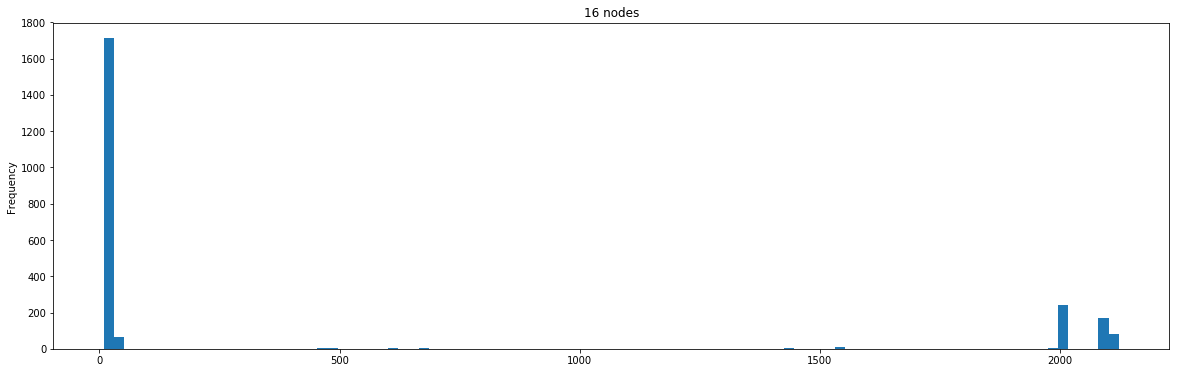

In [22]:
for nnodes in sorted(dfs.keys()):
    fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
    dfs[nnodes]['summary'].plot(kind = 'hist', bins = 100, ax = ax, title = str(nnodes) + ' nodes')

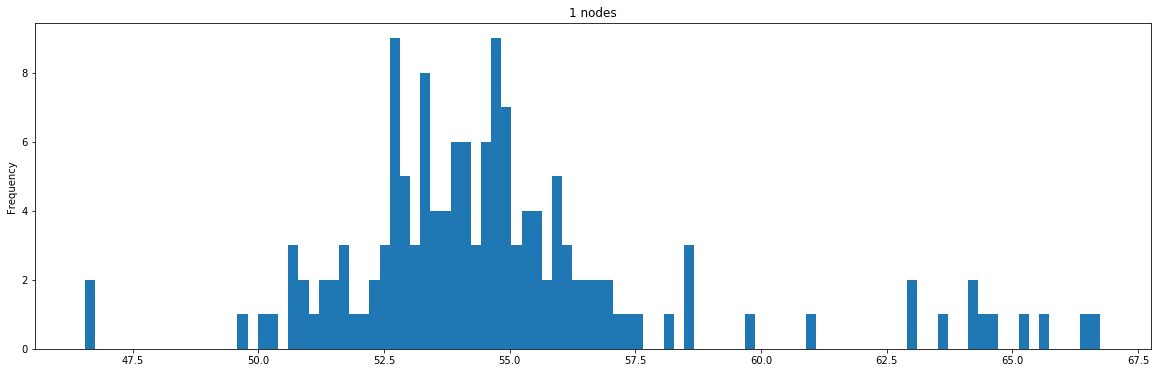

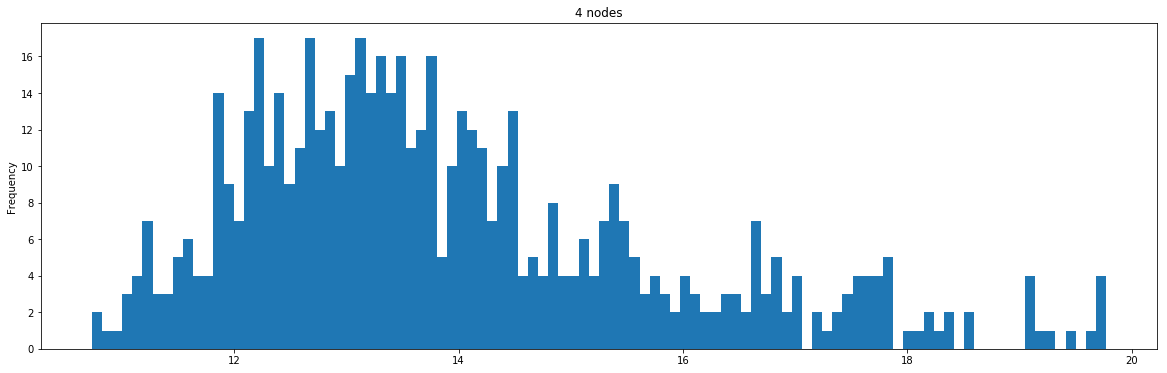

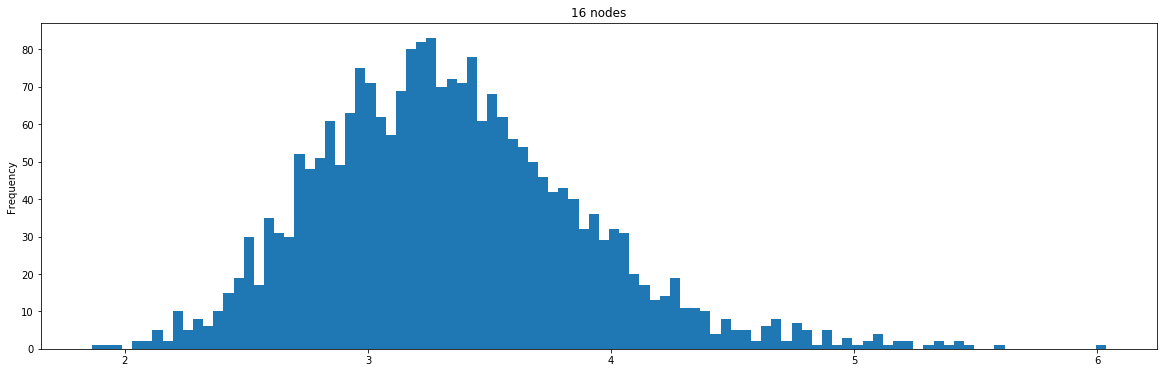

In [24]:
for nnodes in sorted(dfs.keys()):
    fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
    dfs[nnodes]['metadata'].plot(kind = 'hist', bins = 100, ax = ax, title = str(nnodes) + ' nodes')